In [1]:
import sys
import numpy as np
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import scipy.optimize as op
import copy
sys.path.insert(0, '/home/ryan/projects/CHARM-KASTr/py/')
from extraction import *

In [2]:
run floader.py

In [3]:
b = median(BIAS)

f = median(FLAT)

sf = bias_subtract(f, b)

m = create_mask(sf,b)

nf = normalize_flat(sf,m)


In [4]:
gfile = fits.open('/home/ryan/projects/KASTr_data/raw/data-2017-08-12-shane-Adam.Burgasser/red/1035/r1033.fits')

g = gfile[0].data

gsub = bias_subtract(g, b)

gvar_im = variance_image(gsub)

gnorm = normalize_image(gsub, nf, m)

gvar_im_norm = normalize_image(gvar_im, nf, m)

gm = mask_image(gnorm, m)

pfit = slit_fit(gm)

g_weight = weight_function(gm, pfit)

gspec = extract_spectrum(gm, pfit, g_weight)

gvar = extract_variance(gvar_im_norm, pfit, g_weight)

2725
2725


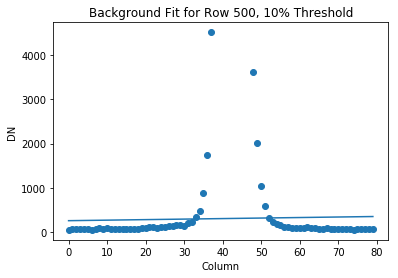

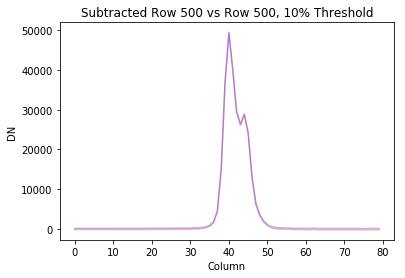

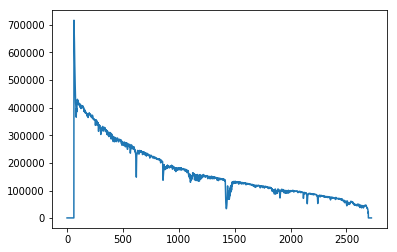

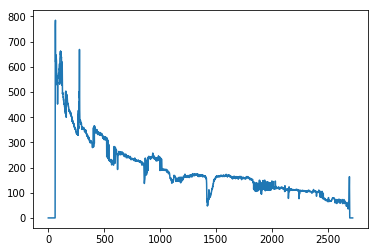

In [5]:
cent_slc = []

for i in range(len(gm[:,0])):
    
    slc = gm[i,:]
    
    cent_slc.append(slc[ int((np.around(pfit(i)) - 40)) : int((np.around(pfit(i)) + 40))])

background_slices = []
background_indices = []
for i in range(len(cent_slc)):
    slc_max = np.amax(cent_slc[i])
    
    background_px = []
    background_ix = []
    
    for j in range(len( cent_slc[i] )):
        if (np.divide(cent_slc[i][j], slc_max) < 0.1):
            background_px.append( cent_slc[i][j])
            background_ix.append(j)
    
    if background_px != []:
        background_slices.append(background_px)
        background_indices.append(background_ix)
    else:
        background_slices.append(np.zeros(len(cent_slc[i])))
        background_indices.append(range(len(cent_slc[i])))

'''
for i in range(len(background_slices)):
    plt.scatter(background_indices[i], background_slices[i])

plt.xlabel('Column')
plt.ylabel('DN')
plt.title('Scatter Plot of all Background')
plt.savefig('Scatter Plot of Background.png', type='png')

plt.show()

'''

'''
plt.scatter(background_indices[500], background_slices[500])
plt.xlabel('Column')
plt.ylabel('DN')
plt.title('Background of Row 500 With Fit')

plt.savefig('Background of Row 500.png', type='png')

plt.show()
'''

background_fits = []

for i in range(len(background_slices)):
    background_fits.append(np.poly1d(np.polyfit(background_indices[i], background_slices[i], 1)))
    

colrange = range(len(cent_slc[500]))

'''
for i in range(len(background_slices)):
    plt.scatter(background_indices[i], background_slices[i])
    plt.plot(colrange, background_fits[i](colrange))
plt.show()
'''

signal_slc = copy.deepcopy(cent_slc)

back_slc = []

print(len(signal_slc))
print(len(background_fits))

for i in range(len(signal_slc)):
    for j in range(len(signal_slc[i])):
        signal_slc[i][j] = signal_slc[i][j] - background_fits[i](j)
        
    back_slc.append( background_fits[i](40))

'''
for i in range(len(cent_slc)):
    plt.plot(cent_slc[i])
    
plt.show()
for i in range(len(signal_slc)):
    plt.plot(signal_slc[i])
plt.show()
for i in range(len(back_slc)):
    plt.plot(back_slc[i])
plt.show()

plt.plot(np.sum(signal_slc, axis=1))
plt.show()

plt.plot(np.sum(back_slc, axis=1))
plt.show()
'''

plt.scatter( background_indices[500], background_slices[500])
plt.plot(colrange, background_fits[500](colrange))
plt.xlabel('Column')
plt.ylabel('DN')
plt.title('Background Fit for Row 500, 10% Threshold')
'''
plt.savefig('Background Fit for Row 500, 10% Threshold.png', type='png')
'''
plt.show()

plt.plot(signal_slc[500], alpha=0.3, color='r')
plt.plot(cent_slc[500], alpha=0.3, color='b')
plt.xlabel('Column')
plt.ylabel('DN')
plt.title('Subtracted Row 500 vs Row 500, 10% Threshold')
'''
plt.savefig('Subtracted Row 500 vs Row 500, 10% Threshold', type='png')
'''
plt.show()

plt.plot(np.sum(signal_slc, axis=1))
plt.show()

plt.plot(back_slc)
plt.show()


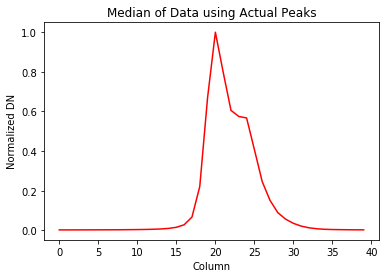

In [5]:

cent_slc_arg = []

for i in range(len(gm[:,0])):
    
    slc = gm[i,:]
    
    
    slc = slc / np.amax(slc)
    
    peakpos = np.argmax(slc)
    
    cs = slc[ (peakpos - 20): (peakpos + 20)]
    
    
    if (len(cs) != 0):
        cent_slc_arg.append(cs)
plt.plot(np.median(cent_slc_arg, axis=0), color='r')
plt.xlabel('Column')
plt.ylabel('Normalized DN')
plt.title('Median of Data using Actual Peaks')
plt.savefig("Actual Peaks Median.png", type='png')
plt.show()

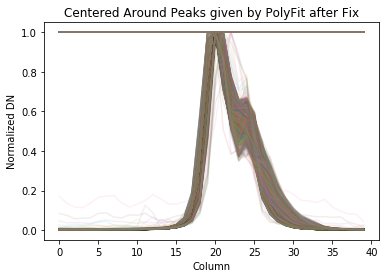

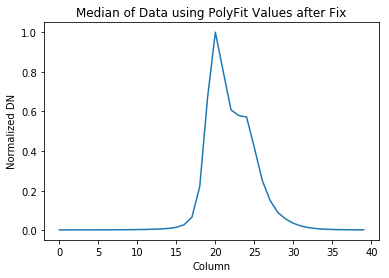

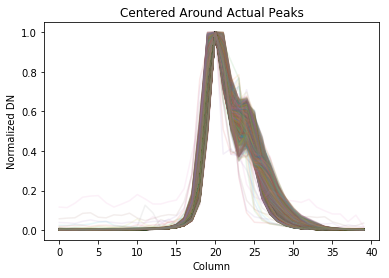

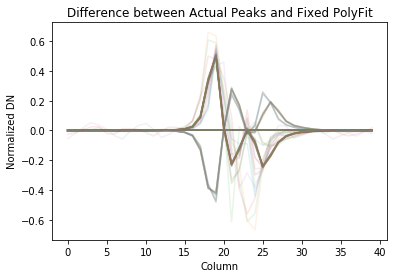

'\nplt.xlabel(\'Column\')\nplt.ylabel(\'Normalized DN\')\nplt.title(\'Median DN of Columns +-20 px from Peak Value\')\nplt.savefig("Cols +- 20 px from Peak.png", type=\'png\')\n'

In [5]:
cent_slc_poly = []

cent_slc_arg = []

for i in range(len(gm[:,0])):
    
    slc = gm[i,:]
    
    
    slc = slc / np.amax(slc)
    
    peakpos = np.argmax(slc)
    
    cent_slc_poly.append(slc[ int((np.around(pfit(i)) - 20)) : int((np.around(pfit(i)) + 20))])
    
    cent_slc_arg.append(slc[ (peakpos - 20): (peakpos + 20)])



for i in range(len(cent_slc_poly)):
    plt.plot(cent_slc_poly[i], alpha=0.1)


plt.xlabel('Column')
plt.ylabel('Normalized DN')
plt.title('Centered Around Peaks given by PolyFit after Fix')
'''
plt.savefig("Peaks given by PolyFit after Fix.png", type='png')
'''

plt.show()




plt.plot(np.median(cent_slc_poly, axis=0))

plt.xlabel('Column')
plt.ylabel('Normalized DN')
plt.title('Median of Data using PolyFit Values after Fix')
'''
plt.savefig("PolyFit Median after Fix.png", type='png')
'''
plt.show()



for i in range(len(cent_slc_arg)):
    plt.plot(cent_slc_arg[i], alpha=0.1)

plt.xlabel('Column')
plt.ylabel('Normalized DN')
plt.title('Centered Around Actual Peaks')
'''
plt.savefig("Actual Peaks for Data.png", type='png')
'''
plt.show()


for i in range(len(cent_slc_poly)):
    
    try:
    
        plt.plot(cent_slc_arg[i] - cent_slc_poly[i] , alpha=0.1)
    except:
        continue

plt.xlabel('Column')
plt.ylabel('Normalized DN')
plt.title('Difference between Actual Peaks and Fixed PolyFit')


plt.savefig("New Difference.png", type='png')


plt.show()

'''
plt.xlabel('Column')
plt.ylabel('Normalized DN')
plt.title('Median DN of Columns +-20 px from Peak Value')
plt.savefig("Cols +- 20 px from Peak.png", type='png')
'''

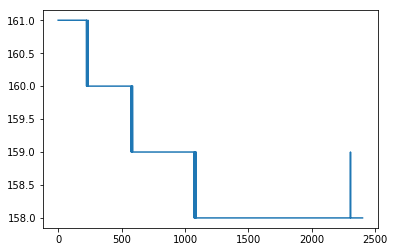

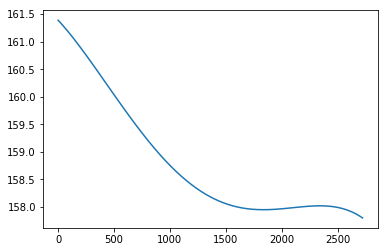

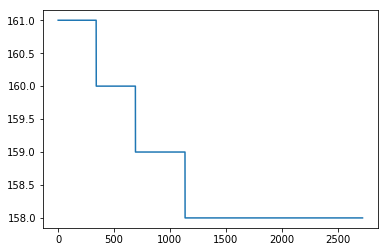

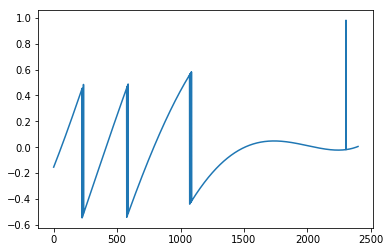

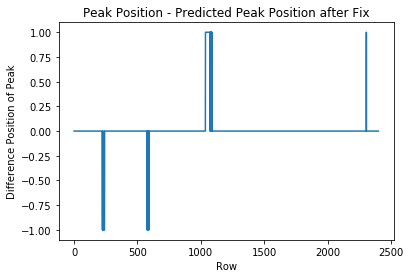

In [10]:
peak_pos = []
row_dex = []
poly_pos = []
pred_pos = []
for i in range(len(gm[:,0])):
    slc = gm[i,:]
    peak_pos.append(np.argmax(slc))
    row_dex.append(i)
    
    poly_pos.append( pfit(i))
    
    pred_pos.append( int(np.around(pfit(i))))
    
    
plt.plot(peak_pos[100:2500])
'''
plt.xlabel('Row')
plt.ylabel('Position of Peak')
plt.title('Actual Peak Positions from Rows 100-2500')
plt.savefig("Actual Peaks.png", type='png')
'''
plt.show()
plt.plot(poly_pos)
'''
plt.xlabel('Row')
plt.ylabel('Position of Peak')
plt.title('Polynomial values for Rows 100-2500')
plt.savefig("Polynomial Values.png", type='png')
'''
plt.show()
plt.plot(pred_pos)
'''
plt.xlabel('Row')
plt.ylabel('Position of Peak')
plt.title('Polynomial Values Cast to Int Rows 100-2500')
plt.savefig("Polynomial Values Cast to Int.png", type='png')
'''
plt.show()

plt.plot(np.subtract(peak_pos[100:2500] , poly_pos[100:2500]))
plt.show()
plt.plot(np.subtract(peak_pos[100:2500], pred_pos[100:2500]))

plt.xlabel('Row')
plt.ylabel('Difference Position of Peak')
plt.title('Peak Position - Predicted Peak Position after Fix')
plt.savefig("Difference Between Peak Predictions after Fix.png", type='png')

plt.show()

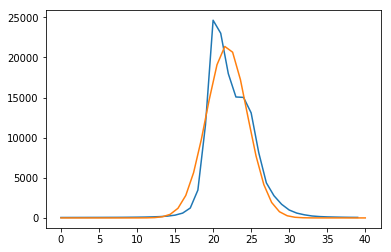

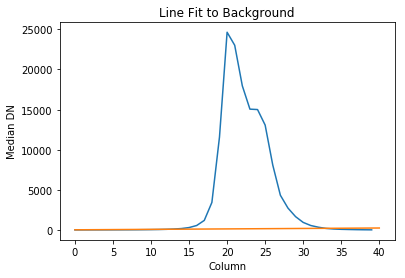

'\nNext steps:\nFind out how to get stats from my fits (currently not able to)\nUse Gaussian fit to determine what columns are background\nWrap up this routine into a function\nSubtracting off this line from data before extraction\n'

In [8]:


cent_slc = []

'''
Increasing the Width of Consideration in hoping to get more background
Trying +- 15, then incrementing up by 5
RESULT:
Going to about +-20 out seems to keep enough backgound
As expected, it's not perfectly symmetric
'''
for i in range(len(gm[:,0])):
    slc = gm[i,:]
        
    cent_slc.append(slc[ int(pfit(i) - 20):int(pfit(i) + 20)])
med_slc = np.median(cent_slc, axis=0)


'''
Looks like Cols 15 to 30 are good data, rest maybe background
'''

xrange = np.arange(15, 30)


def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

p0 = [1., 10., 2.]

popt, pcov = op.curve_fit(gauss, xrange, med_slc[15:30], p0=p0)

plt.plot(med_slc)

plotrange = np.linspace(0, len(med_slc), len(med_slc))

plt.plot( plotrange, gauss(plotrange, popt[0],popt[1],popt[2]))
'''
plt.xlabel('Column')
plt.ylabel('Median DN')
plt.title('Median DN of Columns +-20 px from Peak Value')
plt.savefig("Gaussian Fit +-20 Cols.png", type='png')
'''
plt.show()

crange1 = np.arange(0, 15)
crange2 = np.arange(30, 40)

bkg_px = np.concatenate( (crange1, crange2), axis=None)

bkg_vals = np.concatenate( (med_slc[0:15], med_slc[30:]), axis=None)

bkg_fit = np.poly1d(np.polyfit(bkg_px, bkg_vals, 1))


plt.plot(med_slc)
plt.plot(plotrange, bkg_fit(plotrange))

plt.xlabel('Column')
plt.ylabel('Median DN')
plt.title('Line Fit to Background')
'''
plt.savefig("Line Fit to Background.png", type='png')
'''
plt.show()

'''
Next steps:
Find out how to get stats from my fits (currently not able to)
Use Gaussian fit to determine what columns are background
Wrap up this routine into a function
Subtracting off this line from data before extraction
'''


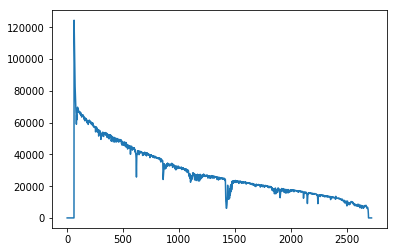

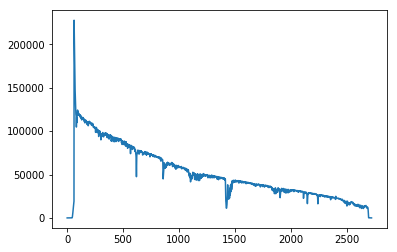

In [5]:
plt.plot(gspec)
plt.show()

plt.plot(gvar)
plt.show()

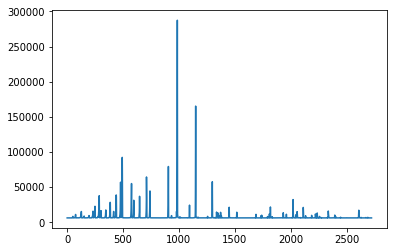

In [6]:
arcdata = ARC[0][0].data

arcd = copy.deepcopy(arcdata)

arc_slc = []

for i in range(len(arcd[:,0])):
    slc = arcd[i,:]
    arc_slc.append(slc[ int(np.around(pfit(i) - 3)):int(np.around(pfit(i) + 3))])
    
plt.plot(np.sum(arc_slc, axis=1))

986
478 57049
492 60308
493 92379
494 68874
575 54760
576 55114
710 64469
905 53267
906 79383
983 53869
984 101340
985 275082
986 287491
987 52645
1149 119531
1150 165330
1299 57672


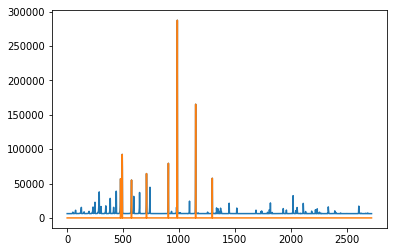

In [7]:
arc_d = np.sum(arc_slc, axis=1)

plt.plot(arc_d)
'''
plt.savefig('arc_spectrumhr.png', type='png', dpi=400)
'''

above50000d = []
above50000i = []

a5d = []
a5i = []

for i in range( len(arc_d)):
    if (arc_d[i] > 50000):
        a5d.append(arc_d[i])
        a5i.append(i)

for i in range( len(arc_d)):
    if (arc_d[i] > 50000):
        above50000d.append(arc_d[i])
        above50000i.append(i)
    else:
        above50000d.append(0)
        above50000i.append(i)

print(np.argmax( arc_d))
plt.plot(above50000i, above50000d)

for i in range(len(a5d)):
    print( a5i[i], a5d[i])


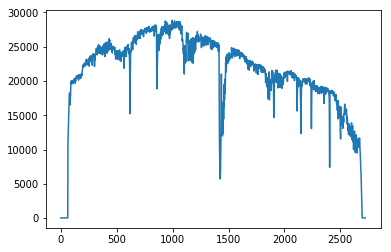

In [8]:
g_1042 = fits.open('/home/ryan/projects/KASTr_data/raw/data-2017-08-12-shane-Adam.Burgasser/red/1038/r1042.fits')

g_1042data = g_1042[0].data

g_1042_sub = bias_subtract(g_1042data, b)

g_1042_norm = normalize_image(g_1042_sub, nf, m)

g_1042_masked = mask_image(g_1042_sub, m)

poly = slit_fit(g_1042_masked)

g_1042_weight = weight_function(g_1042_masked, poly)

g_1042_spec = extract_spectrum(g_1042_masked, poly, g_1042_weight)

plt.plot(g_1042_spec)

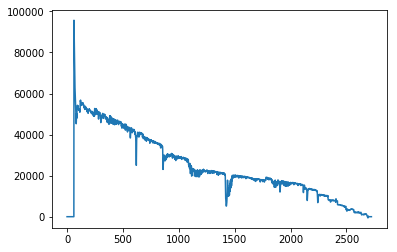

In [9]:
t = SCIENCE[0][0].data

tsub = bias_subtract(t, b)

tvar = variance_image(tsub)

tnorm = normalize_image(tsub, nf, m)

tm = mask_image(tnorm, m)

tf = extract_spectrum(tm, pfit, g_weight)

plt.plot(tf)

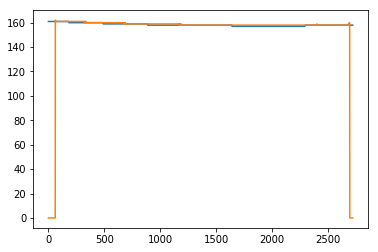

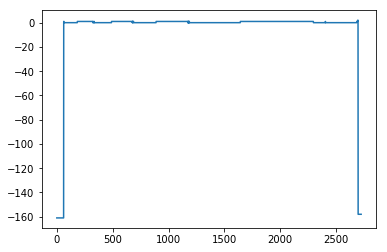

In [23]:
slitfitmax = []

actualmax = np.argmax(gm, axis=1)

for i in range(len(gm[:,0])):
    slitfitmax.append(int(pfit(i)))
    
plt.plot(slitfitmax)
plt.plot(actualmax)
'''
plt.savefig('Polynomial Fit Peaks and Actual Peaks.png', type='png')
'''
plt.show()

plt.plot(actualmax - slitfitmax)

'''
plt.savefig('Difference between Actual Max Position and Slit Fit')
'''

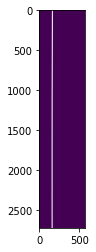

In [17]:

xrange = range(len(gm[:,0]))
fig, ax = plt.subplots()
ax.imshow(gm)
ax.plot(pfit(xrange), xrange, color = 'w', linewidth=1)

'''
fig.savefig('Polynomial Fit on Slit.pdf', type='pdf')
'''

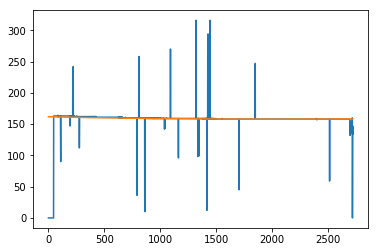

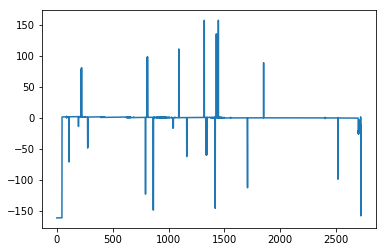

In [23]:
peaks = np.argmax(tm, axis=1)

xrange = np.arange(0, len(tm), 1)

plt.plot(peaks)
plt.plot(pfit(xrange))
plt.show()

plt.plot((peaks - pfit(xrange)))

In [7]:
ghdul = fits.open('/home/ryan/projects/CHARMKASTR/raw/data-2017-08-12-shane-Adam.Burgasser/red/test1035/science/r1033.fits')

g_star = ghdul[0].data

In [8]:
g_subtr = bias_subtract(g_star, b)

g_var = variance_image(g_subtr)


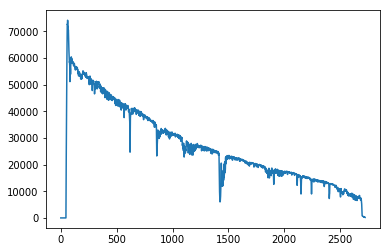

In [6]:
testg = copy.deepcopy(g_subtr)

testg_norm = normalize_image(testg, nf)

testg_masked = mask_image(testg_norm, m)


p = slit_fit(testg_masked)

testslc = []
for i in range(len(testg_masked[:, 0])):
    slc = testg_masked[i,:]
    testslc.append(slc[int(p(i)-10):int(p(i)+10)])


testw = []

for i in range(len(testslc)):
    slc = testslc[i]
    smax = np.amax(slc)
    smedian = np.median(slc)
        
    slc = slc - smedian
    slc = slc / smax
    
    testw.append(slc)

testwfunc = np.median(testw, axis=0)

testflx = []

for i in range(len(testslc)):
    for j in range(len(testslc[i])):
        if testwfunc[j] < 0.1:
            testslc[i][j] = testslc[i][j] - np.median(testslc[i])
            
        testslc[i][j] = testslc[i][j] * testwfunc[j]
        
    testflx.append(np.sum(testslc[i]) / np.sum(testwfunc)) 
    
plt.plot(testflx)

In [16]:
asd[1,:]

array([-2.,  4.,  4.,  2.,  0., -1.,  1.,  3.,  1., -5., -3., -2.,  2.,
       -4., -3.,  2.,  1., -4.,  2.,  0.,  2.,  0.,  5.,  2., -1.,  5.,
       -5., -4., -1.,  0.,  0., -1., -2.,  6., -1.,  1.,  1.,  2., -1.,
        2., -3., -3.,  0.,  1., -2.,  2., -4., -2.,  2.,  5.,  1.,  2.,
       -1.,  0., -4.,  2.,  3.,  2., -1.,  0.,  3.,  0.,  2.,  1.,  1.,
        0.,  8.,  3.,  0., -1.,  4.,  7.,  1.,  3.,  2.,  4.,  7.,  3.,
       -3., -2., -2.,  0., 11.,  2., -5.,  1.,  4.,  4.,  3.,  0.,  4.,
        1.,  4.,  1.,  5.,  6.,  6.,  6.,  2., -2.,  2.,  9.,  7.,  5.,
        3.,  3.,  3.,  4.,  6.,  3.,  6.,  3.,  6.,  2.,  5.,  0.,  4.,
        6.,  5.,  2.,  2.,  3.,  6.,  6.,  4.,  6.,  3.,  6.,  7.,  5.,
        5.,  6.,  7.,  0.,  7.,  4.,  3.,  4.,  9.,  7.,  8.,  3.,  1.,
        0.,  9.,  8., 11.,  5.,  6.,  8.,  6.,  5.,  9.,  4.,  7.,  8.,
        2.,  5.,  8.,  7.,  7.,  4.,  6.,  2.,  7.,  4.,  4.,  7.,  3.,
        1.,  4.,  2.,  4.,  3.,  0.,  5.,  2.,  4.,  4.,  1.,  1

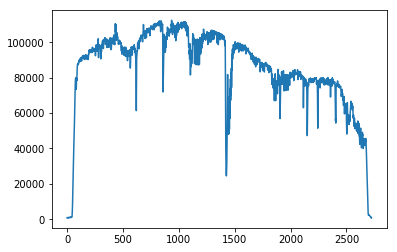

In [26]:
asd = copy.deepcopy(g_subtr)

bsd = copy.deepcopy(asd)

bsd = bsd / np.amax(nf)
plt.plot(np.sum(bsd, axis=1))

In [7]:
g_median = np.median(g_norm)

In [8]:
g_masked = copy.deepcopy(g_norm)

for i in range (g_masked.shape[0]):
    for j in range(g_masked.shape[1]):
        if m[i][j] == 1:
            g_masked[i][j] = g_median
            

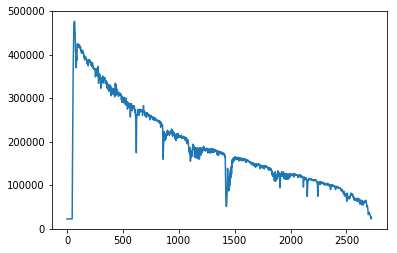

In [9]:
plt.plot(np.sum(g_masked, axis=1))

In [10]:
xpk = np.argmax(g_masked, axis=1)

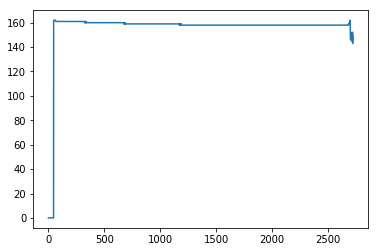

In [11]:
plt.plot(xpk)

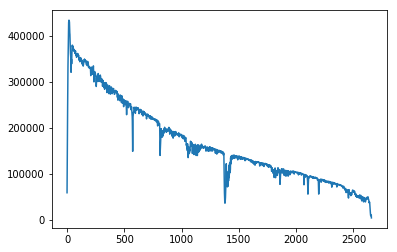

In [12]:
xpeak = []
impc = []
for i in range(len(g_masked[:,0])):
    slc = g_masked[i,:]
    xpeak.append(np.argmax(slc))
    if xpeak[-1] > 150 and xpeak[-1] < 165:
        impc.append(slc[xpeak[-1]-10:xpeak[-1]+10])
plt.plot(np.sum(impc,axis=1))

In [13]:
yrange = np.arange(0, xpk.size, 1)

fitxpk = copy.deepcopy(xpk)

xpkmedian = np.median(xpk)

'''
How to deal with outliers (identification and masking)?

Currently, just looking at the plot of x vs y and seeing a suitable range
if outside that range, masking by replacing with the median value.
'''

for i in range(xpk.size):
    if xpk[i] <= 155 or xpk[i] >= 165:
        fitxpk[i] = xpkmedian

'''
Fitting:
How to determine whether a 3rd order or 4th order fit is better?
Is there a higher order equivalent of an R^2?
'''
p = np.poly1d(np.polyfit(yrange, fitxpk, 3))

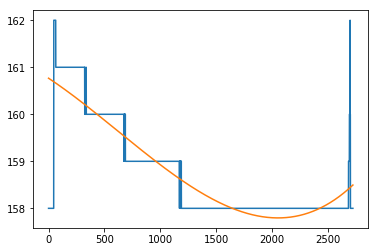

In [14]:
plt.plot(fitxpk)
plt.plot(yrange, p(yrange))

In [15]:
islc = []
for i in range(len(g_masked[:, 0])):
    slc = g_masked[i,:]
    islc.append(slc[int(p(i)-10):int(p(i)+10)])

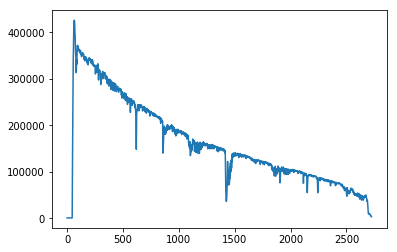

In [16]:
plt.plot(np.sum(islc, axis=1))

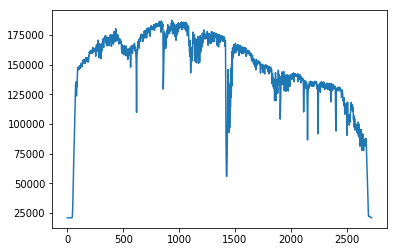

In [17]:
testslc = []
for i in range(len(g_star[:, 0])):
    slc = g_star[i,:]
    testslc.append(slc[int(p(i)-10):int(p(i)+10)])
    
plt.plot(np.sum(testslc, axis=1))

In [18]:
fslc = []
tslc = copy.deepcopy(islc)
for i in range(len(islc)):
    slc = tslc[i]
    smax = np.amax(slc)
    smedian = np.median(slc)
        
    slc = slc - smedian
    slc = slc / smax
    
    fslc.append(slc)


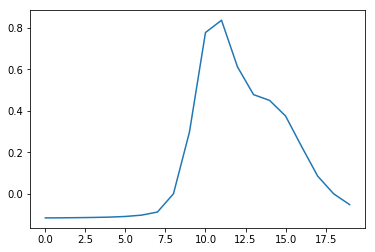

In [19]:
#median along which axis for the weighting function?

plt.plot(np.median(fslc, axis=0))



In [20]:
wfunc = np.median(fslc, axis=0)


In [21]:
flx = []
xslc = copy.deepcopy(islc)

for i in range(len(xslc)):
    for j in range(len(xslc[i])):
        if wfunc[j] < 0.1:
            xslc[i][j] = xslc[i][j] - np.median(xslc[i])
            
        xslc[i][j] = xslc[i][j] * wfunc[j]
        
    flx.append(np.sum(xslc[i]) / np.sum(wfunc)) 
        

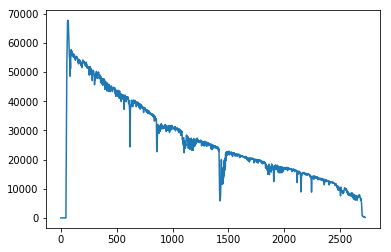

In [22]:
plt.plot(flx)

In [7]:
testg_norm = copy.deepcopy(g_norm)

for i in range(len(testg_norm)):
    testg_norm[i] = testg_norm[i] / np.amax(nf[i])


testg_masked = copy.deepcopy(testg_norm)
testg_median = np.median(testg_norm)

for i in range (testg_masked.shape[0]):
    for j in range(testg_masked.shape[1]):
        if m[i][j] == 1:
            testg_masked[i][j] = testg_median
            
plt.plot(np.sum(testg_masked, axis=1))

NameError: name 'g_norm' is not defined

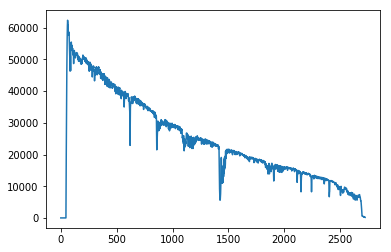

In [9]:
plt.plot(testflx)

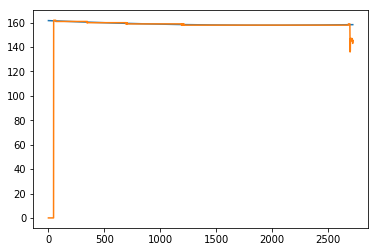

In [14]:
t = np.arange(0, len(testg_masked), 1)

gxpk = np.argmax(testg_masked, axis=1)

plt.plot(t, p(t))
plt.plot(gxpk)